In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# import Qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.tools.visualization import plot_histogram
#from sklearn.preprocessing import MinMaxScaler
from qiskit.aqua.components.feature_maps.raw_feature_vector import RawFeatureVector
from mpl_toolkits.mplot3d import Axes3D

import warnings
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore", category=DeprecationWarning) 



In [20]:
def draw_plot(fig,points,centers,label=True):   
    ax = Axes3D(fig)
    ax.scatter(points[:,1], points[:,2],points[:,3],c=centers, cmap='viridis') #4dimensions
    #ax.scatter(points[:,0], points[:,1],points[:,2],c=centers, cmap='viridis')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    fig.add_axes(ax)
    plt.show()

def get_invariantmass_classical(p1, p2):
    dis=abs((p1[0]+p2[0])**2-(p1[1]+p2[1])**2-(p1[2]+p2[2])**2-(p1[3]+p2[3])**2)**0.5
    #dis=abs((p1[0]-p2[0])**2-(p1[1]-p2[1])**2-(p1[2]-p2[2])**2-(p1[3]-p2[3])**2)**0.5
    return dis
def get_massless_vectors(points):
    fourvector=[]
    for i in range(len(points)):
        aux=np.append(points[i,:], (points[i,0]**2+points[i,1]**2+points[i,2]**2)**0.5)
        aux1=aux.copy()
        aux1[0]=aux[3]
        aux1[1]=aux[0]
        aux1[2]=aux[1]
        aux1[3]=aux[2]
        fourvector+=[aux1]
    return np.array(fourvector)
def quantum_calculate_mass_invariant(x, y):
    backend = Aer.get_backend('qasm_simulator') 
    X = np.array(x[1:4])
    Y = np.array(y[1:4])
    error=False
    if (X[0]==Y[0] and X[1]==Y[1] and X[2]==Y[2]):
        #print('broken')
        return 0,error
        #feature vector converter
    c0 = ClassicalRegister(1)
    q0 = QuantumRegister(1)
    zerocircuit = QuantumCircuit(q0)
    zerocircuit.h(q0)

    fvc = RawFeatureVector(len(X))
    q1 = QuantumRegister(fvc.num_qubits)
    q2 = QuantumRegister(fvc.num_qubits)
    ketxcircuit = fvc.construct_circuit(X, qr=q1)
    ketycircuit = fvc.construct_circuit(Y, qr=q2)

    psicircuit = zerocircuit+ketxcircuit+ketycircuit
    for i in range(fvc.num_qubits):
        psicircuit.cswap(q0, q1[i], q2[i])

    #psicircuit.barrier(q0, q1, q2)


    gatexinverse=ketxcircuit.to_gate().inverse()
    gatexinverse.name="X_inverse"
    gatexinverse=gatexinverse.control(1)
    gateyinverse=ketycircuit.to_gate().inverse()
    gateyinverse.name="Y_inverse"
    gateyinverse=gateyinverse.control(1)

    psicircuit.append(gatexinverse,[0,q2[0],q2[1]])  
    psicircuit.x(q0)
    psicircuit.append(gateyinverse,[0,q2[0],q2[1]]) 
    psicircuit.x(q0)
    Z=0
    for i in range(len(X)):
        Z += X[i]**2+Y[i]**2

    fvc2 = RawFeatureVector(2)
    p1 = np.linalg.norm(X)
    p2 = np.linalg.norm(Y)
    phi = np.array([p1,p2])
    phicircuit = fvc2.construct_circuit(phi, qr=q2)

    q3 = QuantumRegister(1)
    swapcircuit = psicircuit+phicircuit
    swapcircuit.add_register(q3)
    swapcircuit.add_register(c0)
    swapcircuit.h(q3)
    swapcircuit.cswap(q3, q0, q2[0])
    swapcircuit.h(q3)
    swapcircuit.measure(q3, c0)
    swapcircuit.barrier(q0,q1,q2,q3)

    #new things
    q4 = QuantumRegister(1)
    q5 = QuantumRegister(1)
    q6 = QuantumRegister(1)
    phi = np.array([x[0],y[0]])
    Z0=x[0]**2+y[0]**2
    phicircuit = fvc2.construct_circuit(phi, qr=q4)
    swapcircuit=swapcircuit+phicircuit
    swapcircuit.add_register(q5)
    swapcircuit.add_register(q6)
    swapcircuit.h(q5)
    swapcircuit.h(q6)
    c1 = ClassicalRegister(1)
    swapcircuit.cswap(q6, q5, q4)
    swapcircuit.add_register(c1)
    swapcircuit.h(q6)
    swapcircuit.measure(q6, c1)
    #end new things
    
    #print(swapcircuit.draw('latex_source'))
    shots=5000
    result = execute(swapcircuit, backend, shots=shots).result()
    #print(result.get_counts())
    if('1 0' in result.get_counts()):
         p0=(result.get_counts()['1 0']+result.get_counts()['0 0'])/shots
    else:
        p0=(result.get_counts()['0 0'])/shots
    if('0 1' in result.get_counts()):
        p02=(result.get_counts()['0 0']+result.get_counts()['0 1'])/shots
    else:
        p02=(result.get_counts()['0 0'])/shots
    #squares = Z*((4*result.get_counts()['0']/50000.0)-2)
    tridistance = (Z*(4*p0-2))
    difmodulus=(Z0*(4*p02-2))
    
    if (tridistance<0 or difmodulus<0 ):
        error=True
    minkq2=abs(difmodulus-tridistance)**0.5
    #error =False
    return(minkq2,error)

def process_noexp(points):
    maximum=points.max()
    minimum=points.min()
    points_std=(points-minimum)/(maximum-minimum)
    points_scaled=points_std*(10-1)+1
    return (points_scaled)

def makeitinteger(centers):
    intcenters=[int(centers[0])]
    for i in range(1,len(centers)):
        integer=int(centers[i])
        intcenters=np.append(intcenters,int(integer))
    return intcenters
def compute_efficiency(o_centers,intcenters):
    eff=0
    #intcenters=makeitinteger(centers)
    for i in range(len(intcenters)):
        if (o_centers[i]==intcenters[i]):
            eff+=1
    return (eff/len(intcenters))
def changing_index(a,b,intcenters):
    intcentersaux=np.where(intcenters==a, b,intcenters)
    intcenters=np.where(intcenters==b,a,intcentersaux)
    return intcenters
def final_efficiency(o_centers,centers,k):
    effmax=0
    intcenters=makeitinteger(centers)
    goodcenters=intcenters.copy()
    for i in range(0,k-1):
        for j in range(0,k):#1
            intcentersaux=changing_index(i,j,intcenters)
            
            eff=compute_efficiency(o_centers,intcentersaux)
            
            if(eff>effmax):
                effmax=eff
                goodcenters=intcentersaux
    return (effmax,goodcenters)
def final_efficiency_converged(o_centers,centers,k):
    intcenters=makeitinteger(centers)
    stop=0
    ef,intcenters=final_efficiency(o_centers,intcenters,k)# we are changing intcenters 
    while (stop==0):
        efprime,intcentersprime=final_efficiency(o_centers,intcenters,k)
        if (efprime==ef):
            stop=1
        else:
            ef=efprime
            intcenters=intcentersprime
    return (ef,intcenters)
def transform_all_to_angular_4(data_momentum_vector):
    data_angular_vector=data_momentum_vector.copy()
    for i in range(len(data_momentum_vector)):
        data_angular_vector[i]=transform_to_angular_4(data_momentum_vector[i])
    
    return(data_angular_vector)

def transform_to_angular_4(data_momentum):
    data_angular=data_momentum.copy()
    data_angular[0]=(data_momentum[0]**2+data_momentum[1]**2)**0.5
    data_angular[1]=0.5*log((data_momentum[3]+data_momentum[2])/
                            (data_momentum[3]-data_momentum[2]))
    data_angular[2]=math.atan(data_momentum[1]/data_momentum[0])
    if(data_momentum[0]<0):
        data_angular[2]+=pi
    data_angular[3]=(data_momentum[3]**2-data_momentum[2]**2)**0.5#m_T
    return(data_angular)

def exchange_p0_2(data):
    data_aux=data.copy()
    for i in range(len(data)):
        data_aux[i,0]=data[i,3]
        data_aux[i,1]=data[i,0]
        data_aux[i,2]=data[i,1]
        data_aux[i,3]=data[i,2]
    return data_aux
def draw_plot_angular3(fig,points,centers):
    
    ax = Axes3D(fig,azim=-30,elev=30,auto_add_to_figure=False)
    #ax = plt.axes(projection ="3d")
    ax.scatter(points[:,2], points[:,1],points[:,0],c=centers, cmap='viridis') #4dimensions
    #ax.scatter(points[:,0], points[:,1],points[:,2],c=centers, cmap='viridis')
    #print(points[centers==8])
    ax.set_ylabel('$y$')
    ax.set_xlabel('$\phi$')
    ax.set_zlabel('$p_T$ [GeV]')
    fig.add_axes(ax)
    plt.show()  
    return (fig)
from math import log,pi
import math

Estimated number of clusters: 4
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


<ipython-input-12-82e4006994ac>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


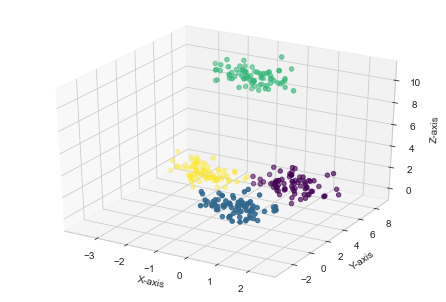

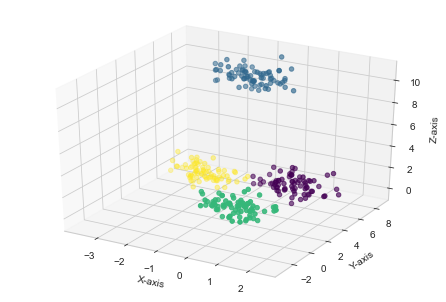

In [13]:
# #############################################################################
# Generate sample data
k=4
X4c, labels_true4c = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X04c=get_massless_vectors(X4c)
mat4c = np.empty(shape=(len(X04c),len(X04c)))
for i in range(len(X04c)):
    for j in range(len(X04c)):
        mat4c[i,j]=-get_invariantmass_classical(X04c[i],X04c[j])**2
# #############################################################################
# Compute Affinity Propagation

af4c = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat4c)

cluster_centers_indices4c = af4c.cluster_centers_indices_
labels4c = af4c.labels_

n_clusters_4c = len(cluster_centers_indices4c)

print("Estimated number of clusters: %d" % n_clusters_4c)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true4c, labels4c))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true4c, labels4c))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true4c, labels4c))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true4c, labels4c))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true4c, labels4c)
)

fig4c=plt.figure()
draw_plot(fig4c,X04c[:,:],labels_true4c)
fig24c=plt.figure()
draw_plot(fig24c,X04c[:,:],labels4c)

Estimated number of clusters: 5
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


<ipython-input-12-82e4006994ac>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


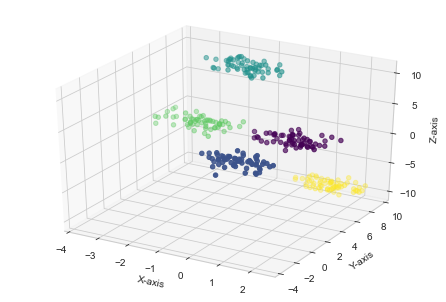

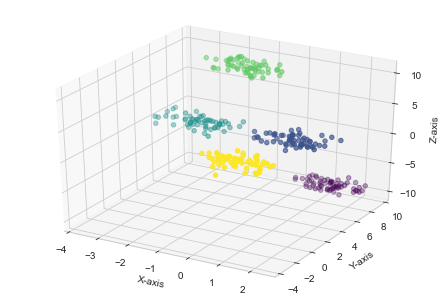

In [16]:
# #############################################################################
# CLASSIC
k=5
X5c, labels_true5c = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X05c=get_massless_vectors(X5c)
mat5c = np.empty(shape=(len(X05c),len(X05c)))
for i in range(len(X05c)):
    for j in range(len(X05c)):
        mat5c[i,j]=-get_invariantmass_classical(X05c[i],X05c[j])**2

# #############################################################################
# Compute Affinity Propagation

af5c = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat5c)

cluster_centers_indices5c = af5c.cluster_centers_indices_
labels5c = af5c.labels_

n_clusters_5c = len(cluster_centers_indices5c)

print("Estimated number of clusters: %d" % n_clusters_5c)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true5c, labels5c))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true5c, labels5c))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true5c, labels5c))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true5c, labels5c))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true5c, labels5c)
)
fig5c=plt.figure()
draw_plot(fig5c,X05c[:,:],labels_true5c)
fig25c=plt.figure()
draw_plot(fig25c,X05c[:,:],labels5c)

Estimated number of clusters: 6
Homogeneity: 0.991
Completeness: 0.991
V-measure: 0.991
Adjusted Rand Index: 0.992
Adjusted Mutual Information: 0.991


<ipython-input-12-82e4006994ac>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


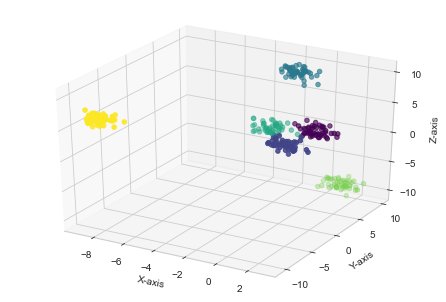

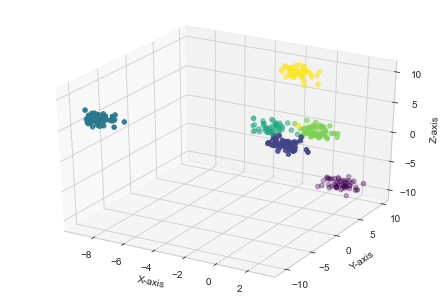

In [17]:
# #############################################################################
# CLASSIC
k=6
X6c, labels_true6c = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X06c=get_massless_vectors(X6c)
mat6c = np.empty(shape=(len(X06c),len(X06c)))
for i in range(len(X06c)):
    for j in range(len(X06c)):
        mat6c[i,j]=-get_invariantmass_classical(X06c[i],X06c[j])**2

# Compute Affinity Propagation

af6c = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat6c)

cluster_centers_indices6c = af6c.cluster_centers_indices_
labels6c = af6c.labels_

n_clusters_6c = len(cluster_centers_indices6c)

print("Estimated number of clusters: %d" % n_clusters_6c)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true6c, labels6c))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true6c, labels6c))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true6c, labels6c))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true6c, labels6c))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true6c, labels6c)
)

fig6c=plt.figure()
draw_plot(fig6c,X06c[:,:],labels_true6c)
fig26c=plt.figure()
draw_plot(fig26c,X06c[:,:],labels6c)

Estimated number of clusters: 7
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


<ipython-input-12-82e4006994ac>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


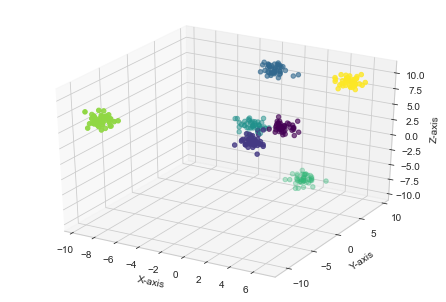

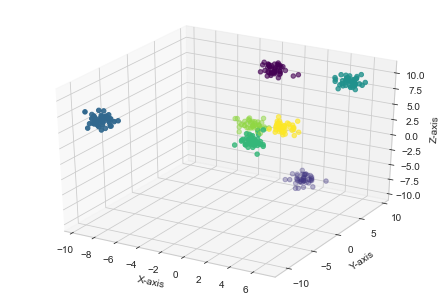

In [18]:
# #############################################################################
# CLASSIC
k=7
X7c, labels_true7c = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X07c=get_massless_vectors(X7c)
mat7c = np.empty(shape=(len(X07c),len(X07c)))
for i in range(len(X07c)):
    for j in range(len(X07c)):
        mat7c[i,j]=-get_invariantmass_classical(X07c[i],X07c[j])**2
# Compute Affinity Propagation

af7c = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat7c)

cluster_centers_indices7c = af7c.cluster_centers_indices_
labels7c = af7c.labels_

n_clusters_7c = len(cluster_centers_indices7c)

print("Estimated number of clusters: %d" % n_clusters_7c)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true7c, labels7c))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true7c, labels7c))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true7c, labels7c))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true7c, labels7c))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true7c, labels7c)
)

fig7c=plt.figure()
draw_plot(fig7c,X07c[:,:],labels_true7c)
fig27c=plt.figure()
draw_plot(fig27c,X07c[:,:],labels7c)

Estimated number of clusters: 8
Homogeneity: 0.987
Completeness: 0.987
V-measure: 0.987
Adjusted Rand Index: 0.985
Adjusted Mutual Information: 0.987


<ipython-input-12-82e4006994ac>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


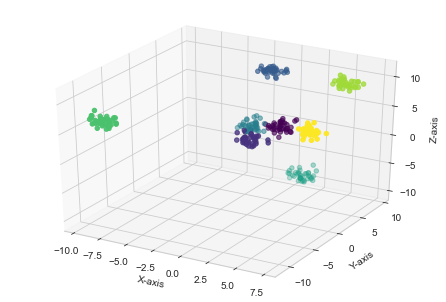

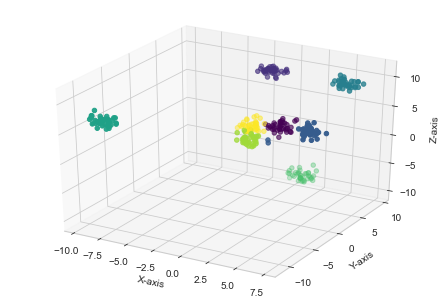

In [19]:
# #############################################################################
# CLASSIC
k=8
X8c, labels_true8c = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X08c=get_massless_vectors(X8c)
mat8c = np.empty(shape=(len(X08c),len(X08c)))
for i in range(len(X08c)):
    for j in range(len(X08c)):
        mat8c[i,j]=-get_invariantmass_classical(X08c[i],X08c[j])**2

# Compute Affinity Propagation

af8c = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat8c)

cluster_centers_indices8c = af8c.cluster_centers_indices_
labels8c = af8c.labels_

n_clusters_8c = len(cluster_centers_indices8c)

print("Estimated number of clusters: %d" % n_clusters_8c)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true8c, labels8c))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true8c, labels8c))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true8c, labels8c))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true8c, labels8c))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true8c, labels8c)
)

fig8c=plt.figure()
draw_plot(fig8c,X08c[:,:],labels_true8c)
fig28c=plt.figure()
draw_plot(fig28c,X08c[:,:],labels8c)

Estimated number of clusters: 4
Homogeneity: 0.987
Completeness: 0.987
V-measure: 0.987
Adjusted Rand Index: 0.991
Adjusted Mutual Information: 0.987


<ipython-input-20-a22050dd3096>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


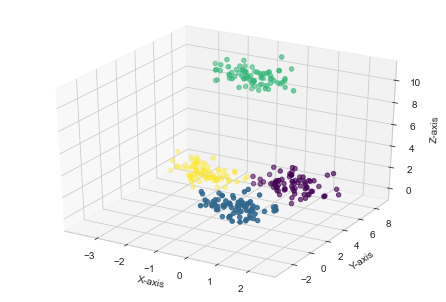

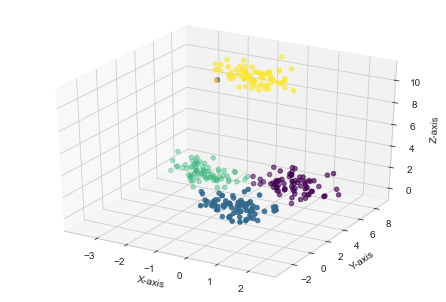

In [21]:
# #############################################################################
# QUANTUM
k=4
X4q, labels_true4q = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X04q=get_massless_vectors(X4q)
mat4q = np.empty(shape=(len(X04q),len(X04q)))
for i in range(len(X04q)):
    for j in range(len(X04q)):
        mat4q[i,j]=-quantum_calculate_mass_invariant(X04q[i],X04q[j])[0]**2
# #############################################################################
# Compute Affinity Propagation

af4q = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat4q)

cluster_centers_indices4q = af4q.cluster_centers_indices_
labels4q = af4q.labels_

n_clusters_4q = len(cluster_centers_indices4q)

print("Estimated number of clusters: %d" % n_clusters_4q)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true4q, labels4q))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true4q, labels4q))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true4q, labels4q))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true4q, labels4q))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true4q, labels4q)
)

fig4q=plt.figure()
draw_plot(fig4q,X04q[:,:],labels_true4q)
fig24q=plt.figure()
draw_plot(fig24q,X04q[:,:],labels4q)

Estimated number of clusters: 5
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


/tmp/ipykernel_3585/3110987450.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


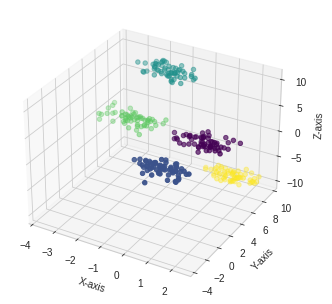

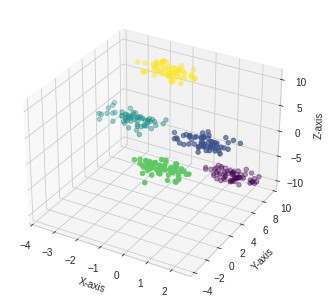

In [76]:
# #############################################################################
# QUANTUM
k=5
X5q, labels_true5q = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X05q=get_massless_vectors(X5q)
mat5q = np.empty(shape=(len(X05q),len(X05q)))
for i in range(len(X05q)):
    for j in range(len(X05q)):
        mat5q[i,j]=-quantum_calculate_mass_invariant(X05q[i],X05q[j])[0]**2

# #############################################################################
# Compute Affinity Propagation

af5q = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat5q)

cluster_centers_indices5q = af5q.cluster_centers_indices_
labels5q = af5q.labels_

n_clusters_5q = len(cluster_centers_indices5q)

print("Estimated number of clusters: %d" % n_clusters_5q)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true5q, labels5q))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true5q, labels5q))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true5q, labels5q))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true5q, labels5q))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true5q, labels5q)
)

fig5q=plt.figure()
draw_plot(fig5q,X05q[:,:],labels_true5q)
fig25q=plt.figure()
draw_plot(fig25q,X05q[:,:],labels5q)

Estimated number of clusters: 6
Homogeneity: 0.975
Completeness: 0.975
V-measure: 0.975
Adjusted Rand Index: 0.976
Adjusted Mutual Information: 0.975


/tmp/ipykernel_3585/3110987450.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


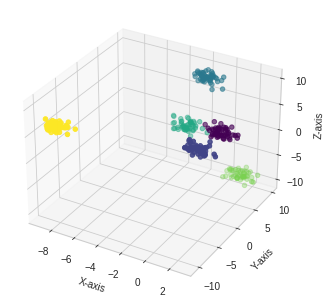

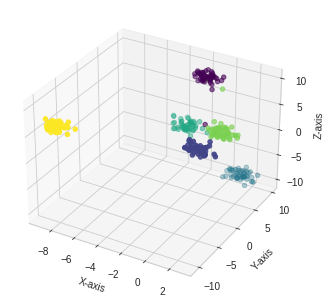

In [77]:
# #############################################################################
# QUANTUM
k=6
X6q, labels_true6q = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X06q=get_massless_vectors(X6q)
mat6q = np.empty(shape=(len(X06q),len(X06q)))
for i in range(len(X06q)):
    for j in range(len(X06q)):
        mat6q[i,j]=-quantum_calculate_mass_invariant(X06q[i],X06q[j])[0]**2
# #############################################################################
# Compute Affinity Propagation
af6q = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat6q)

cluster_centers_indices6q = af6q.cluster_centers_indices_
labels6q = af6q.labels_

n_clusters_6q = len(cluster_centers_indices6q)

print("Estimated number of clusters: %d" % n_clusters_6q)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true6q, labels6q))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true6q, labels6q))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true6q, labels6q))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true6q, labels6q))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true6q, labels6q)
)

fig6q=plt.figure()
draw_plot(fig6q,X06q[:,:],labels_true6q)
fig26q=plt.figure()
draw_plot(fig26q,X06q[:,:],labels6q)

Estimated number of clusters: 7
Homogeneity: 0.981
Completeness: 0.981
V-measure: 0.981
Adjusted Rand Index: 0.977
Adjusted Mutual Information: 0.981


/tmp/ipykernel_3585/3110987450.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


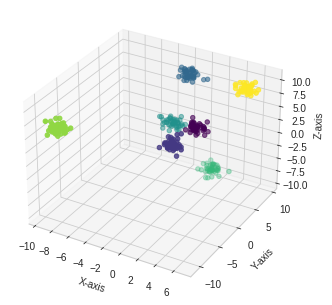

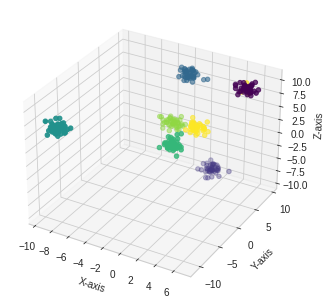

In [78]:
# #############################################################################
# QUANTUM
k=7
X7q, labels_true7q = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X07q=get_massless_vectors(X7q)
mat7q = np.empty(shape=(len(X07q),len(X07q)))
for i in range(len(X07q)):
    for j in range(len(X07q)):
        mat7q[i,j]=-quantum_calculate_mass_invariant(X07q[i],X07q[j])[0]**2
# #############################################################################
# Compute Affinity Propagation

af7q = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat7q)

cluster_centers_indices7q = af7q.cluster_centers_indices_
labels7q= af7q.labels_

n_clusters_7q = len(cluster_centers_indices7q)

print("Estimated number of clusters: %d" % n_clusters_7q)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true7q, labels7q))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true7q, labels7q))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true7q, labels7q))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true7q, labels7q))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true7q, labels7q)
)

fig7q=plt.figure()
draw_plot(fig7q,X07q[:,:],labels_true7q)
fig27q=plt.figure()
draw_plot(fig27q,X07q[:,:],labels7q)

Estimated number of clusters: 8
Homogeneity: 0.978
Completeness: 0.978
V-measure: 0.978
Adjusted Rand Index: 0.977
Adjusted Mutual Information: 0.977


/tmp/ipykernel_3585/3110987450.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


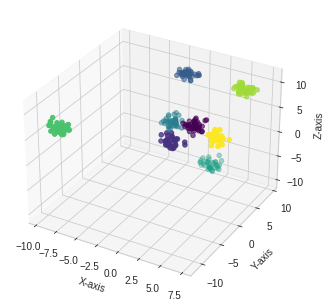

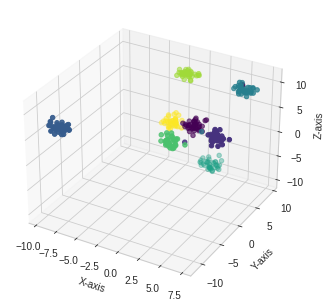

In [80]:
# #############################################################################
# QUANTUM
k=8
X8q, labels_true8q = make_blobs(n_samples=300, n_features=3,centers=k, cluster_std=0.6,
                            random_state=0)

X08q=get_massless_vectors(X8q)
mat8q = np.empty(shape=(len(X08q),len(X08q)))
for i in range(len(X08q)):
    for j in range(len(X08q)):
        mat8q[i,j]=-quantum_calculate_mass_invariant(X08q[i],X08q[j])[0]**2
# #############################################################################
# Compute Affinity Propagation

af8q = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat8q)

cluster_centers_indices8q = af8q.cluster_centers_indices_
labels8q= af8q.labels_

n_clusters_8q = len(cluster_centers_indices8q)

print("Estimated number of clusters: %d" % n_clusters_8q)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true8q, labels8q))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true8q, labels8q))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true8q, labels8q))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true8q, labels8q))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true8q, labels8q)
)

fig8q=plt.figure()
draw_plot(fig8q,X08q[:,:],labels_true8q)
fig28q=plt.figure()
draw_plot(fig28q,X08q[:,:],labels8q)

In [6]:
real_data=np.loadtxt('realdata.txt')
print(real_data)
exchanged_data=exchange_p0_2(real_data)
print(exchanged_data)

[[-4.74990e+02 -7.17592e+02  4.12870e+02  9.54472e+02]
 [-1.24095e+01 -2.50566e+02 -4.62284e+02  5.25969e+02]
 [-2.46284e+02 -1.65597e+02  1.76266e+01  2.97303e+02]
 [ 9.19041e+01 -1.41064e+02 -3.32783e+01  1.71618e+02]
 [-9.02416e+01 -4.21089e+01  8.92479e+00  9.99818e+01]
 [ 2.90168e+01 -7.95067e+01 -1.51314e+01  8.59782e+01]
 [ 1.07819e+00 -1.22750e+02 -1.83301e+01  1.24115e+02]
 [-6.30852e+01 -4.20113e-01  1.20374e+01  6.42248e+01]
 [-3.57283e+00 -1.42179e+01 -2.29556e+00  1.48385e+01]
 [-2.52748e+00  2.10184e+00  1.67752e+00  3.69053e+00]
 [-1.10272e+00 -2.12537e+01  1.21956e+01  2.45289e+01]
 [-1.40851e+01 -8.90998e+00 -1.37344e+01  2.15966e+01]
 [-1.21386e+02 -9.57483e+01  2.95721e-01  1.54604e+02]
 [ 4.73559e+01 -5.13055e+01 -7.79976e+00  7.02544e+01]
 [-4.19245e+01 -3.64302e+01 -2.24424e+01  5.99040e+01]
 [ 1.12941e+01 -2.44079e+01  1.93372e+01  3.31245e+01]
 [-8.45800e-02 -3.59697e-01  3.32585e-02  3.71001e-01]
 [-7.05742e-02  5.15340e-02 -4.89920e-02  1.00183e-01]
 [ 2.47031

Estimated number of clusters: 2


/tmp/ipykernel_12247/1829936622.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


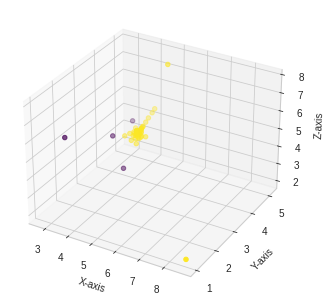

In [7]:
#CLASSIC CLASSIFICACTION OF REAL DATA

Xreal=exchanged_data
Xreal=process_noexp(Xreal)
mat = np.empty(shape=(len(Xreal),len(Xreal)))

for i in range(len(Xreal)):
    for j in range(len(Xreal)):
        mat[i,j]=-get_invariantmass_classical(Xreal[i],Xreal[j])**2
        
# #############################################################################
# Compute Affinity Propagation

af = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(mat)

cluster_centers_indices = af.cluster_centers_indices_
labelsreal= af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

fig2=plt.figure()
draw_plot(fig2,Xreal[:,:],labelsreal)

[[ 1.68360968e+02 -1.96395871e-01 -9.93362848e-01  1.68360603e+02]
 [ 9.95826583e+01  8.95023742e-02  3.57818481e+00  9.95826715e+01]
 [ 8.46362217e+01 -1.77842639e-01 -1.22085638e+00  8.46362311e+01]
 [ 1.22754735e+02 -1.48774438e-01 -1.56201293e+00  1.22753984e+02]
 [ 6.30865988e+01  1.89668158e-01  3.14825201e+00  6.30866542e+01]
 [ 1.46599384e+01 -1.55955169e-01  4.46619565e+00  1.46598597e+01]
 [ 3.28723083e+00  4.90416800e-01  2.44788109e+00  3.28723871e+00]
 [ 2.12822874e+01  5.45570593e-01  4.66055179e+00  2.12822526e+01]
 [ 1.66666669e+01 -7.51347150e-01  3.70562559e+00  1.66667150e+01]
 [ 1.54603680e+02  1.91276656e-03  3.80946196e+00  1.54603717e+02]
 [ 6.98200229e+01 -1.11481206e-01 -8.25408666e-01  6.98200864e+01]
 [ 5.55411845e+01 -3.93809166e-01  3.85698453e+00  5.55412270e+01]
 [ 2.68942796e+01  6.68167750e-01 -1.13741236e+00  2.68943339e+01]
 [ 3.69507386e-01  8.98866138e-02  4.48144212e+00  3.69507259e-01]
 [ 8.73869033e-02 -5.34778189e-01  2.51087779e+00  8.73865975e

<Figure size 432x288 with 0 Axes>

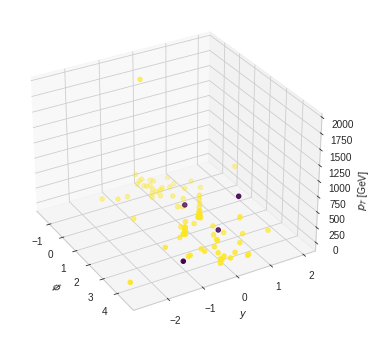

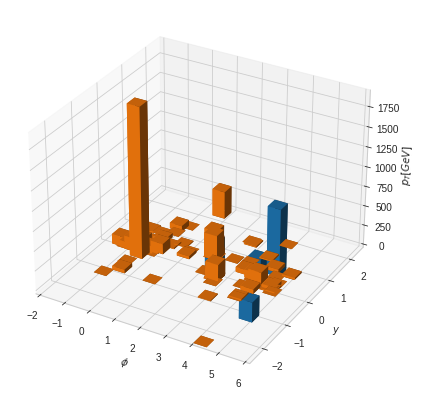

In [8]:
points_ex_angular=transform_all_to_angular_4(real_data)
print(points_ex_angular[labelsreal==1])
fig=plt.figure()
fig=plt.figure(figsize = (6,4.5))
fig=draw_plot_angular3(fig,points_ex_angular,labelsreal)
points_cluster0=points_ex_angular[labelsreal==0]
points_cluster1=points_ex_angular[labelsreal==1]


fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')

ax1.set_xlabel('$\phi$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_xlim([-2.0, 6])
ax1.set_ylim([-2.5, 2.5])
width =0.5
depth = (-2.5- 2.5)/(-2-6)*width
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)


image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'cap_realdata.pdf'
plt.savefig(image_name, format=image_format, dpi=700)
plt.show()

Estimated number of clusters: 2


/tmp/ipykernel_3585/2404090982.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


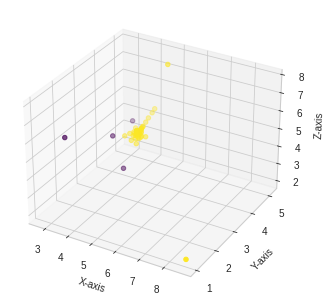

In [16]:
#QUANTUM CLASSIFICACTION OF REAL DATA
Xreal=exchanged_data
Xreal=process_noexp(Xreal)
matq = np.empty(shape=(len(Xreal),len(Xreal)))

for i in range(len(Xreal)):
    for j in range(len(Xreal)):
        matq[i,j]=-quantum_calculate_mass_invariant(Xreal[i],Xreal[j])[0]**2

# #############################################################################
# Compute Affinity Propagation

af2 = AffinityPropagation(preference=-50, affinity="precomputed",random_state=0).fit(matq)

cluster_centers_indices = af2.cluster_centers_indices_
labelsrealq= af2.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

fig2=plt.figure()
draw_plot(fig2,Xreal[:,:],labelsrealq)

[[ 1.68360968e+02 -1.96395871e-01 -9.93362848e-01  1.68360603e+02]
 [ 9.95826583e+01  8.95023742e-02  3.57818481e+00  9.95826715e+01]
 [ 8.46362217e+01 -1.77842639e-01 -1.22085638e+00  8.46362311e+01]
 [ 1.22754735e+02 -1.48774438e-01 -1.56201293e+00  1.22753984e+02]
 [ 6.30865988e+01  1.89668158e-01  3.14825201e+00  6.30866542e+01]
 [ 1.46599384e+01 -1.55955169e-01  4.46619565e+00  1.46598597e+01]
 [ 3.28723083e+00  4.90416800e-01  2.44788109e+00  3.28723871e+00]
 [ 2.12822874e+01  5.45570593e-01  4.66055179e+00  2.12822526e+01]
 [ 1.66666669e+01 -7.51347150e-01  3.70562559e+00  1.66667150e+01]
 [ 1.54603680e+02  1.91276656e-03  3.80946196e+00  1.54603717e+02]
 [ 6.98200229e+01 -1.11481206e-01 -8.25408666e-01  6.98200864e+01]
 [ 5.55411845e+01 -3.93809166e-01  3.85698453e+00  5.55412270e+01]
 [ 2.68942796e+01  6.68167750e-01 -1.13741236e+00  2.68943339e+01]
 [ 3.69507386e-01  8.98866138e-02  4.48144212e+00  3.69507259e-01]
 [ 8.73869033e-02 -5.34778189e-01  2.51087779e+00  8.73865975e

<Figure size 432x288 with 0 Axes>

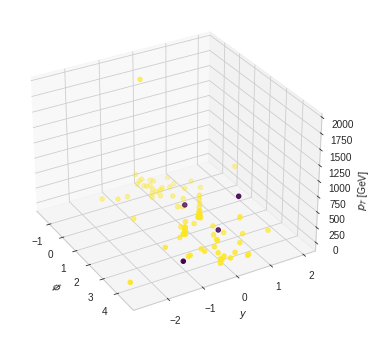

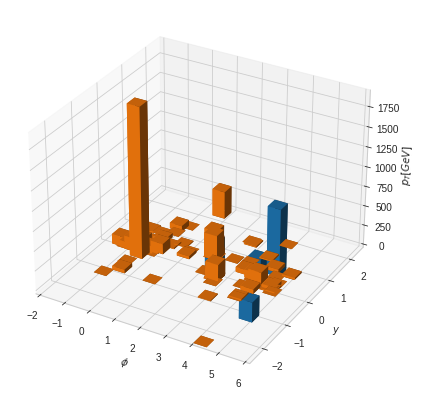

In [81]:
points_ex_angular=transform_all_to_angular_4(real_data)
print(points_ex_angular[labelsrealq==1])
fig=plt.figure()
fig=plt.figure(figsize = (6,4.5))
fig=draw_plot_angular3(fig,points_ex_angular,labelsrealq)
points_cluster0=points_ex_angular[labelsrealq==0]
points_cluster1=points_ex_angular[labelsrealq==1]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')

ax1.set_xlabel('$\phi$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_xlim([-2.0, 6])
ax1.set_ylim([-2.5, 2.5])
width =0.5
depth = (-2.5- 2.5)/(-2-6)*width
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)

image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'qap_realdata2.pdf'
plt.savefig(image_name, format=image_format, dpi=700)
plt.show()

In [73]:
print(final_efficiency_converged(labelsreal,labelsrealq2,2)[0])#shots=500 ef=1
#print(final_efficiency_converged(labelsreal_np,labelsrealq2,2)[0])
print(final_efficiency_converged(labelsreal,labelsrealq2,2)[1])
print(labelsreal)

1.0
0.6796875
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
